In [1]:
import torch
from torchvision import transforms

import torchvision.datasets as datasets
# Using CIFAR-10 dataset
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from torchvision import models

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

from tqdm.notebook import tqdm, trange

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# Load the CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
resnet_pretrained = models.resnet18(pretrained=True)

# replace the final classification layer with identity to get 512‑dim embeddings
resnet_pretrained.fc = torch.nn.Identity()
# move to device and set to eval mode
resnet_pretrained = resnet_pretrained.to('cuda')
resnet_pretrained.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
embeddings = []

for images, labels in tqdm(test_loader):
    # Forward pass through the model
    with torch.no_grad():
        images = torch.nn.functional.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False).cuda()
        
        features = resnet_pretrained(images)
        embeddings.append(features)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
embeddings = torch.cat(embeddings, dim=0)
normed_embeddings = torch.nn.functional.normalize(embeddings, dim=1)

kernel_matrix = normed_embeddings @ normed_embeddings.T
print(kernel_matrix.shape)

torch.Size([10000, 10000])


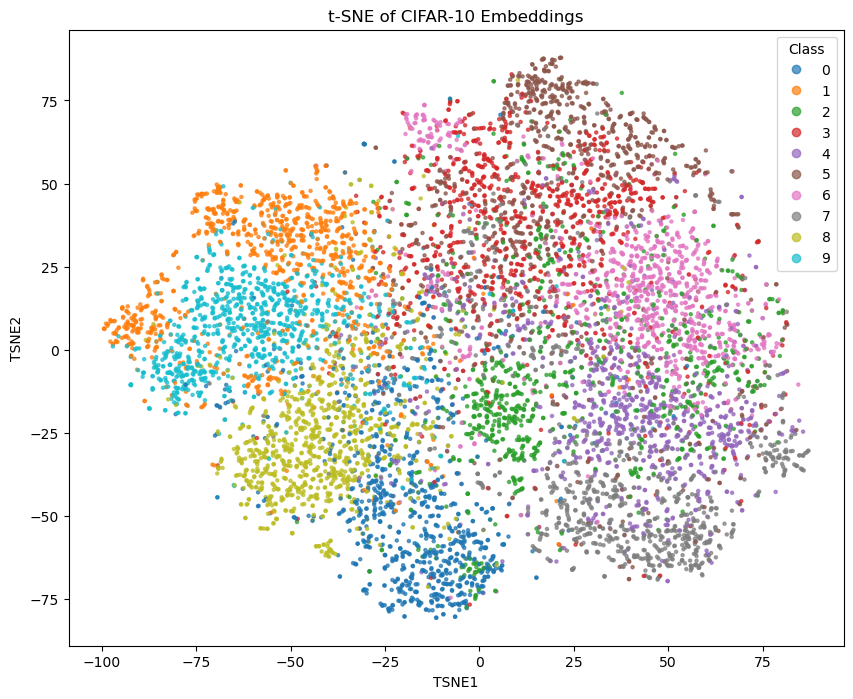

In [5]:
from sklearn.manifold import TSNE

# move embeddings to CPU numpy
emb_np = embeddings.cpu().numpy()

# compute 2D tsne
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
emb_2d = tsne.fit_transform(emb_np)

# get true labels from test_dataset
labels = np.array(test_dataset.targets)

# plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                 c=labels, cmap='tab10', s=5, alpha=0.7)
plt.legend(*sc.legend_elements(), title="Class", loc="best")
plt.title("t-SNE of CIFAR-10 Embeddings")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

/tmp/ipykernel_1688/2042332858.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Acceptance rate : 0.0034
Final f value   :  47905.81568


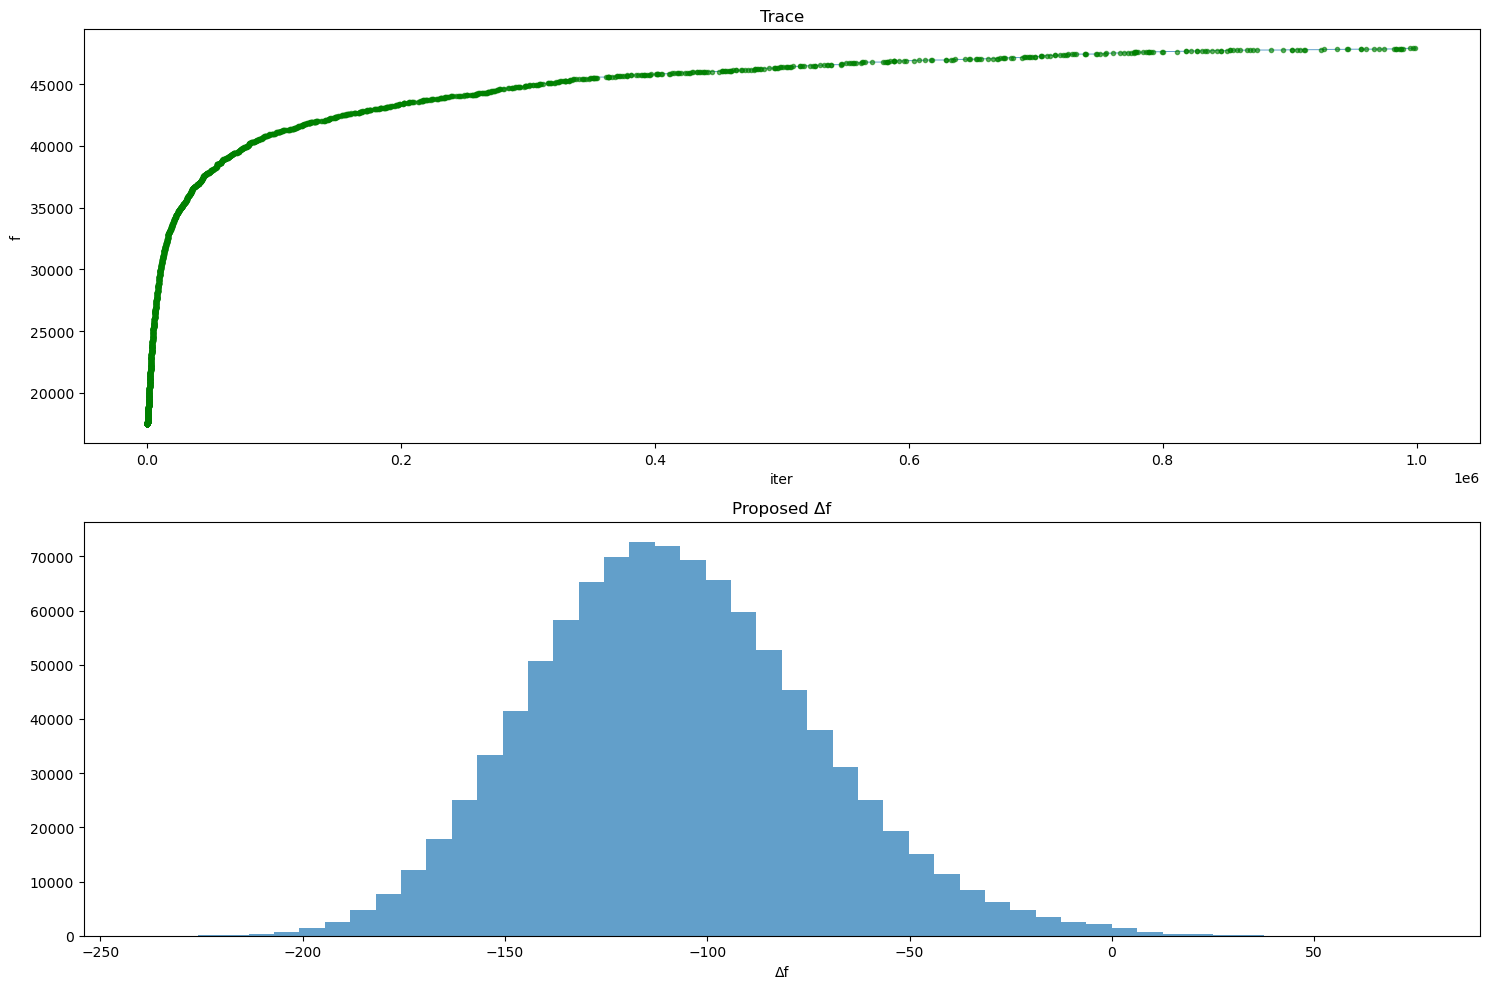

Fraction in class-1: 0.5020999908447266


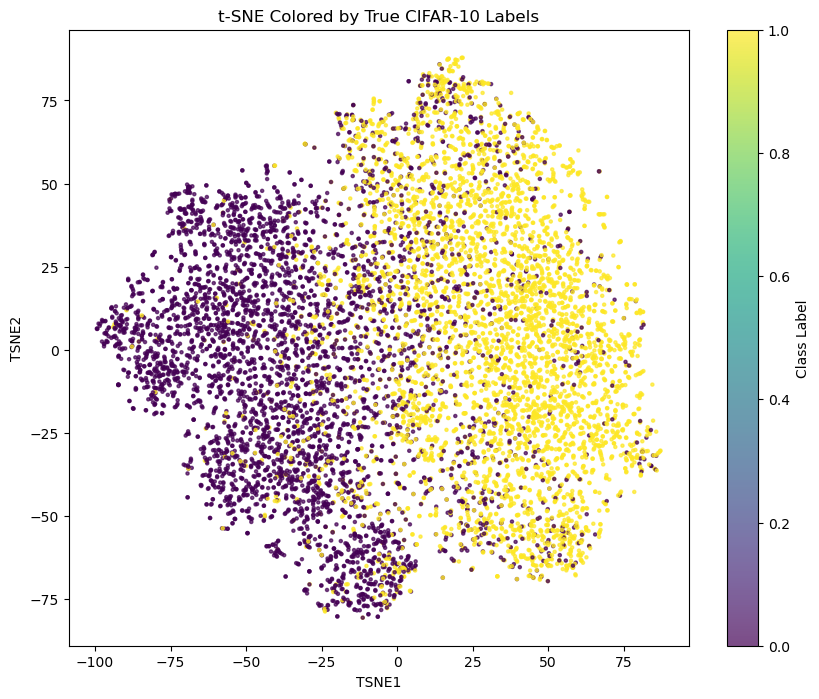

In [21]:
import torch, matplotlib.pyplot as plt
from tqdm.auto import trange
import random

# ============================================================================
#  Generic Metropolis–Hastings sampler for binary-label models on CUDA
# ---------------------------------------------------------------------------
def metropolis_sampler(
        n_iter: int,
        labels_start: torch.Tensor,            # (n,) 0/1 int64 on GPU
        K: torch.Tensor,                       # (n,n) positive-semidef. kernel
        f_fn,                                  # f(K, labels)  → scalar float
        proposal_fn,                           # proposal_fn(labels) → new_labels
        delta_f_fn=None,                       # optional delta_f(K, old, new)
        rng: torch.Generator = None,
        track_diag: bool = True):
    """
    Returns:
        labels_final
        (optionally) diagnostics dict if track_diag is True
    """
    device = labels_start.device
    if rng is None:
        rng = torch.Generator(device=device)

    labels   = labels_start.clone()
    f_curr   = f_fn(K, labels).item()          # initial objective (1 full eval)

    # diagnostic buffers
    if track_diag:
        f_values, f_diffs, accepted_it = [], [], []
        acc_count = 0

    for it in trange(n_iter):
        labels_new = proposal_fn(labels)

        # ------------------------------------------------------------------
        #   objective difference
        # ------------------------------------------------------------------
        if delta_f_fn is not None:
            df = delta_f_fn(K, labels, labels_new)           # fast Δf
        else:
            f_new = f_fn(K, labels_new).item()               # full recompute
            df    = f_new - f_curr

        # ------------------------------------------------------------------
        #   Metropolis decision
        # ------------------------------------------------------------------
        if track_diag:
            f_values.append(f_curr)
            f_diffs .append(df)

        alpha = min(1.0, torch.exp(torch.tensor(df)))
        if torch.rand((), generator=rng, device=device) < alpha:
            labels  = labels_new
            f_curr += df
            if track_diag:
                acc_count    += 1
                accepted_it.append(it)

    # ----------------------------------------------------------------------
    #   Diagnostics & output
    # ----------------------------------------------------------------------
    if track_diag:
        print(f"Acceptance rate : {acc_count / n_iter:.4f}")
        print(f"Final f value   : {f_curr: .5f}")

        plt.figure(figsize=(15, 10))
        plt.subplot(2,1,1)
        plt.plot(f_values, lw=.7, alpha=.7)
        plt.plot(accepted_it,
                 [f_values[i] for i in accepted_it],
                 "g.", alpha=.6)
        plt.title("Trace"); plt.xlabel("iter"); plt.ylabel("f")
        plt.subplot(2,1,2)
        plt.hist(f_diffs, bins=50, alpha=.7)
        plt.title("Proposed Δf"); plt.xlabel("Δf")
        plt.tight_layout(); plt.show()

        return labels, dict(f_values=f_values,
                            f_diffs=f_diffs,
                            accepted_it=accepted_it)

    return labels
# ============================================================================


# ---------------------------------------------------------------------------
#  Example plug-in pieces
# ---------------------------------------------------------------------------

# ----- objective -----
def f_from_labels(K: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    Y = torch.nn.functional.one_hot(labels, num_classes=2).float()
    return 5e-4 * torch.trace(Y @ Y.T @ K)

# ----- fast Δf for an *arbitrary* new label vector (handles block flips) -----
@torch.no_grad()
def delta_f_general(K: torch.Tensor,
                    labels_old: torch.Tensor,
                    labels_new: torch.Tensor) -> float:
    """Compute Δf between two labelings with one masked dot-product each side."""
    # rows that changed
    changed = (labels_old != labels_new).nonzero(as_tuple=False).flatten()
    if changed.numel() == 0:
        return 0.0

    c = 5e-4
    df = 0.0
    for idx in changed:
        row = K[idx]
        new_lbl = labels_new[idx].item()
        old_lbl = 1 - new_lbl
        same_new = (labels_new == new_lbl)
        same_old = (labels_old == old_lbl)
        df += (row[same_new].sum() - row[same_old].sum()).item()

    return 2 * c * df           # factor 2 counts (i,j) and (j,i)
@torch.no_grad()

def delta_f_fast(K: torch.Tensor,
                 labels_old: torch.Tensor,
                 labels_new: torch.Tensor) -> float:
    """
    Vectorised Δf for *any number* of label flips.
    Assumes binary labels {0,1}.  Lives entirely on the GPU.
    Complexity:  O(k·n) arithmetic on GPU;  O(1) Python time.
    """
    changed = (labels_old != labels_new)
    if not changed.any():
        return 0.0

    idxs        = changed.nonzero(as_tuple=False).flatten()        # (k,)
    rows        = K[idxs]                                          # (k, n)

    # -------- masks for "which columns belong to class-0 / 1 after the flip"
    mask0 = (labels_new == 0).float()                              # (n,)
    mask1 = 1.0 - mask0                                            # (n,)

    # -------- class-wise row sums in *one* mat-vec each
    sum0 = (rows * mask0).sum(dim=1)   # (k,)   Σ_j∈class0  K_ij
    sum1 = (rows * mask1).sum(dim=1)   # (k,)   Σ_j∈class1  K_ij

    # new / old class selection
    new_lbl  = labels_new[idxs]
    old_lbl  = labels_old[idxs]

    row_sum_new = torch.where(new_lbl == 0, sum0, sum1)
    row_sum_old = torch.where(old_lbl == 0, sum0, sum1)

    diff = row_sum_new - row_sum_old          # (k,)

    return (.06 * diff.sum()).item()   

# ----- proposal factory: k-flip ------------------------------------------------
def make_k_flip_proposal(k: int,
                         rng: torch.Generator,
                         device: torch.device):
    """Returns proposal(labels)->new_labels that flips *k* random distinct bits."""
    def proposal_k(labels: torch.Tensor) -> torch.Tensor:
        n   = labels.shape[0]
        k_  = min(k, n)
        idx = torch.randperm(n, generator=rng, device=device)[:k_]
        new = labels.clone()
        new[idx] = 1 - new[idx]
        return new
    return proposal_k

def make_balanced_k_flip(k, rng, device):
    def proposal(labels):
        k2 = k // 2
        idx0 = (labels == 0).nonzero().flatten()
        idx1 = (labels == 1).nonzero().flatten()
        if len(idx0) < k2 or len(idx1) < k2:
            return labels.clone()            # degenerate, but safe
        pick0 = idx0[torch.randperm(len(idx0), generator=rng, device=device)[:k2]]
        pick1 = idx1[torch.randperm(len(idx1), generator=rng, device=device)[:k2]]
        new   = labels.clone()
        new[pick0] = 1
        new[pick1] = 0
        return new
    return proposal
# ============================================================================


# ---------------- Example run -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng    = torch.Generator(device=device)

K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)
n      = K_gpu.shape[0]
labels0 = torch.randint(2, (n,), generator=rng, device=device)
# initialize labels0 using CIFAR‐10 labels as prior: pick 5 classes to be “1”

# choose 5 distinct classes out of 0–9
classes1 = random.sample(range(10), 5)

# get the CIFAR‐10 targets (length n == 10000)
cifar_targets = test_dataset.targets

# build labels0: 1 if its CIFAR class is in classes1, else 0
#labels0 = torch.tensor(
#    [1 if lbl in classes1 else 0 for lbl in cifar_targets],
#    dtype=torch.long,
#    device=device
#)

# choose proposal: flip 10 bits at once
#proposal_fn = make_k_flip_proposal(k=10, rng=rng, device=device)
proposal_fn = make_balanced_k_flip(k=10, rng=rng, device=device)

labels_final, diag = metropolis_sampler(
    n_iter      = 1000000,
    labels_start= labels0,
    K           = K_gpu,
    f_fn        = f_from_labels,
    proposal_fn = proposal_fn,
    delta_f_fn  = delta_f_fast,   #   comment this line out to fall back to full f recompute
    rng         = rng,
    track_diag  = True
)

print("Fraction in class-1:", (labels_final == 1).float().mean().item())

plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
            c=labels_final.cpu().numpy(), s=5, alpha=0.7)
plt.colorbar(label='Class Label')
plt.title("t-SNE Colored by True CIFAR‑10 Labels")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()


In [20]:
diffs = labels_final - labels0
print("Fraction of flips:", (diffs != 0).float().mean().item())

Fraction of flips: 0.3716000020503998


In [7]:
#generate 100 sets of labels as above
labels_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng    = torch.Generator(device=device)
K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)
n      = K_gpu.shape[0]

for i in trange(100):
    labels0 = torch.randint(2, (n,), generator=rng, device=device)

    # choose proposal: flip 10 bits at once
    #proposal_fn = make_k_flip_proposal(k=500, rng=rng, device=device)
    proposal_fn = make_balanced_k_flip(k=10, rng=rng, device=device)

    labels_final = metropolis_sampler(
        n_iter      = 100000,
        labels_start= labels0,
        K           = K_gpu,
        f_fn        = f_from_labels,
        proposal_fn = proposal_fn,
        delta_f_fn  = delta_f_fast,   #   comment this line out to fall back to full f recompute
        rng         = rng,
        track_diag  = False
    )

    labels_list.append(labels_final)

/tmp/ipykernel_122993/3695611585.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [8]:
labels_list = torch.stack(labels_list)
labels_list = labels_list.cpu().numpy()
print(labels_list.shape)

#save the labels_list to a file
np.save('labels_list4.npy', labels_list)

#load the labels_list from the file
labels_list = np.load('labels_list4.npy')


(100, 10000)


In [6]:
# ── device helpers ────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng     = torch.Generator(device=device)           # keeps all random ops on-device

# ── proposal kernel (flips a single bit) ──────────────────────────────────────
def proposal_torch(Y: torch.Tensor, *, g=rng) -> torch.Tensor:
    """
    Y : (n, 2) one-hot tensor on GPU
    returns a *new* tensor with one row's hot vector flipped
    """
    n      = Y.shape[0]
    idx    = torch.randint(n, (1,), generator=g, device=device)
    Y_new  = Y.clone()
    Y_new[idx] = 1 - Y_new[idx]           # switch [1,0] <-> [0,1]
    return Y_new

# ── objective (same as before) ────────────────────────────────────────────────
def f_torch(K: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    # 0.0005 * Tr(Y Yᵀ K) ;  result is scalar-tensor on GPU
    return torch.trace(Y @ Y.T @ K)

def proposal_k(labels: torch.Tensor,
               k: int,
               *,                   # make k a keyword-only arg after labels
               g: torch.Generator,  # GPU RNG you already created
               device: torch.device = None) -> torch.Tensor:
    """
    labels  : (n,) int64 tensor with entries 0/1, living on `device`
    k       : how many distinct indices to flip (clipped to n)
    g       : torch.Generator bound to the same device
    returns : *new* tensor with exactly k labels flipped
    """
    if device is None:
        device = labels.device
    n = labels.shape[0]
    k = int(min(k, n))                 # clip in case k > n

    # pick k distinct indices without replacement
    idx = torch.randperm(n, generator=g, device=device)[:k]

    new_labels        = labels.clone()
    new_labels[idx]   = 1 - new_labels[idx]   # 0→1, 1→0

    return new_labels

def adapt_beta(beta, acc_rate, mean_df,   # recent stats
               target_acc=0.35,           # 1️⃣ keep α near 0.35
               damp_acc =0.3,             #   (slow, stable)
               damp_df  =0.05):           # 2️⃣ drive ⟨Δf⟩→0
    # log-space update for stability
    logb = torch.log(torch.tensor(beta))

    # 1️⃣ acceptance feedback
    logb = logb + damp_acc * torch.clamp(acc_rate/target_acc - 1, -1, 1)

    # 2️⃣ centring feedback  (if ⟨Δf⟩>0 shrink β, if <0 enlarge β)
    logb = logb - damp_df * torch.tanh(mean_df / (5.0 * abs(mean_df).mean().clamp(min=1)))

    # clip to a sensible range
    beta_new = torch.exp(logb).clamp(1e-4, 1.0)
    return beta_new.item()


/tmp/ipykernel_55109/1257284264.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)


  0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance rate : 0.0000
Final f value   :  755193.50049


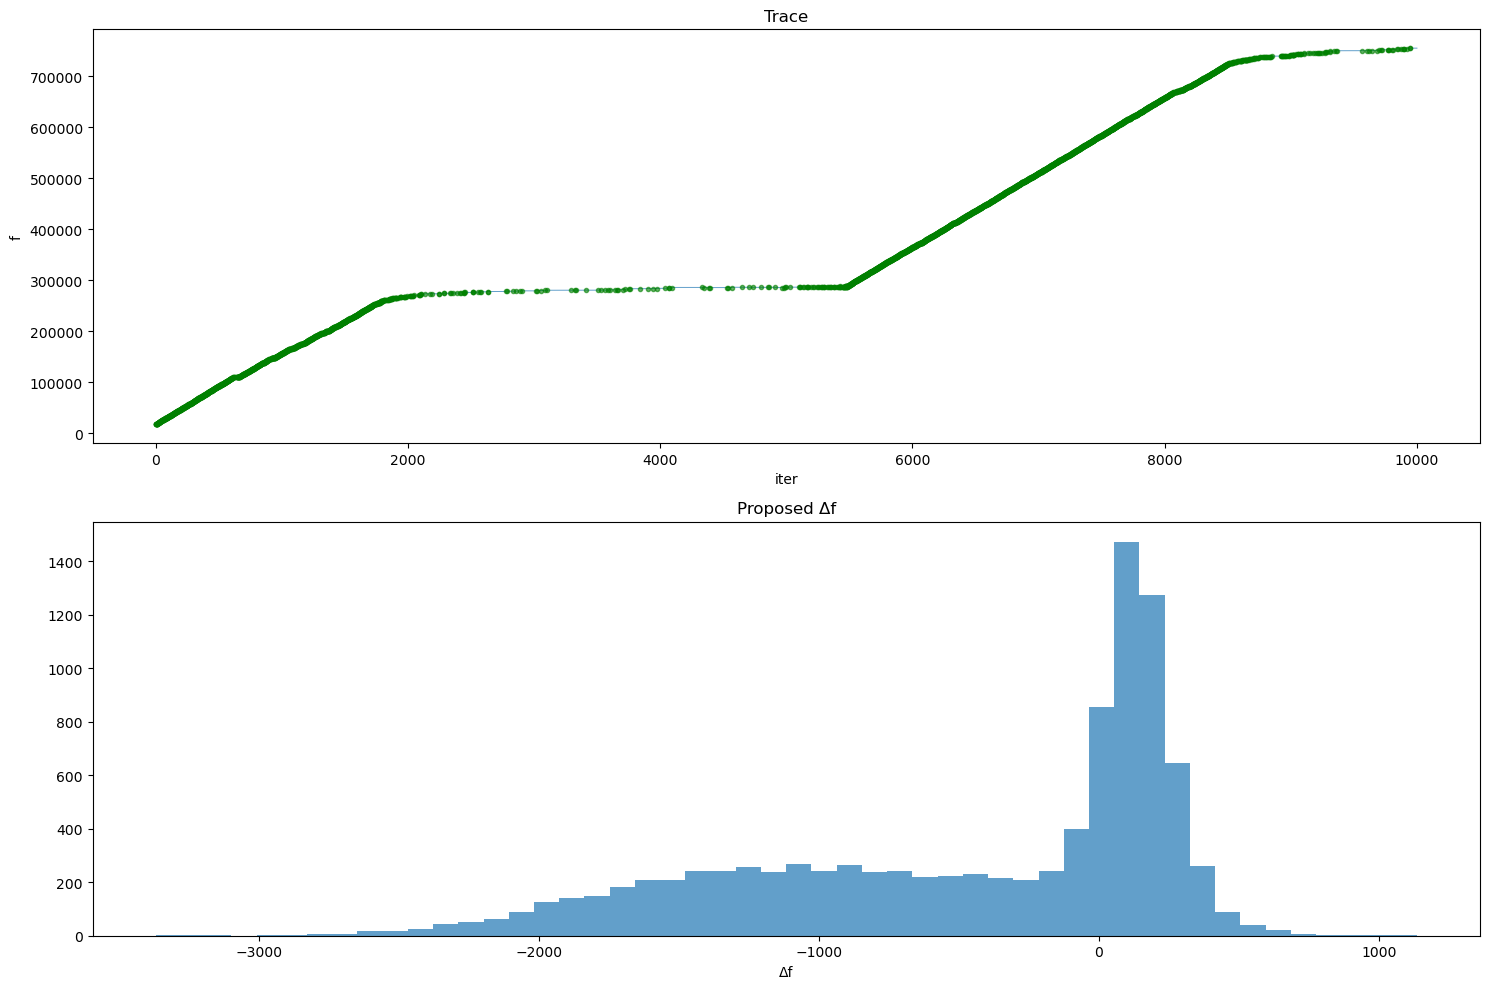

Fraction in class-1: 0.5020999908447266
Mean f value: 394153.1371, Std: 210436.9432
Mean Δf value: -469.6375, Std: 753.6096
Acceptance rate: 0.4838


In [ ]:
import torch, matplotlib.pyplot as plt
from tqdm.auto import trange

# ============================================================================
#  Generic Metropolis–Hastings sampler for binary-label models on CUDA
# ---------------------------------------------------------------------------
def metropolis_sampler(
        n_iter: int,
        labels_start: torch.Tensor,            # (n,) 0/1 int64 on GPU
        K: torch.Tensor,                       # (n,n) positive-semidef. kernel
        f_fn,                                  # f(K, labels)  → scalar float
        proposal_fn,                           # proposal_fn(labels) → new_labels
        invtemp = 1.0,
        delta_f_fn=None,                       # optional delta_f(K, old, new)
        rng: torch.Generator = None,
        track_diag: bool = True,
        auto_tune = False):
    """
    Returns:
        labels_final
        (optionally) diagnostics dict if track_diag is True
    """
    device = labels_start.device
    if rng is None:
        rng = torch.Generator(device=device)

    labels   = labels_start.clone()
    f_curr   = f_fn(K, labels).item()          # initial objective (1 full eval)

    # diagnostic buffers
    f_values, f_diffs, accepted_it = [], [], []
    acc_count = 0

    for it in trange(n_iter):
        labels_new = proposal_fn(labels)

        # ------------------------------------------------------------------
        #   objective difference
        # ------------------------------------------------------------------
        if delta_f_fn is not None:
            df = delta_f_fn(K, labels, labels_new)           # fast Δf
        else:
            f_new = f_fn(K, labels_new).item()               # full recompute
            df    = f_new - f_curr

        # ------------------------------------------------------------------
        #   Metropolis decision
        # ------------------------------------------------------------------
        f_values.append(f_curr)
        f_diffs .append(df)

        alpha = min(1.0, torch.exp(invtemp * torch.tensor(df)))
        if torch.rand((), generator=rng, device=device) < alpha:
            labels  = labels_new
            f_curr += df
            acc_count    += 1
            accepted_it.append(it)

        if auto_tune and (it + 1) % 1000 == 0:
            acc_rate = acc_count / 1000
            if acc_rate < 0.2:
                invtemp *= 0.5          # raise temperature
            elif acc_rate > 0.6:
                invtemp *= 2.0          # lower temperature
            acc_count = 0

    # ----------------------------------------------------------------------
    #   Diagnostics & output
    # ----------------------------------------------------------------------
    if track_diag:
        print(f"Acceptance rate : {acc_count / n_iter:.4f}")
        print(f"Final f value   : {f_curr: .5f}")

        plt.figure(figsize=(15, 10))
        plt.subplot(2,1,1)
        plt.plot(f_values, lw=.7, alpha=.7)
        plt.plot(accepted_it,
                 [f_values[i] for i in accepted_it],
                 "g.", alpha=.6)
        plt.title("Trace"); plt.xlabel("iter"); plt.ylabel("f")
        plt.subplot(2,1,2)
        plt.hist(f_diffs, bins=50, alpha=.7)
        plt.title("Proposed Δf"); plt.xlabel("Δf")
        plt.tight_layout(); plt.show()

        return labels, dict(f_values=f_values,
                            f_diffs=f_diffs,
                            accepted_it=accepted_it)

    return labels
# ============================================================================


# ---------------------------------------------------------------------------
#  Example plug-in pieces
# ---------------------------------------------------------------------------

# ----- objective -----
def f_from_labels(K: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    Y = torch.nn.functional.one_hot(labels, num_classes=2).float()
    return 5e-4 * torch.trace(Y @ Y.T @ K)

# ----- fast Δf for an *arbitrary* new label vector (handles block flips) -----
@torch.no_grad()
def delta_f_general(K: torch.Tensor,
                    labels_old: torch.Tensor,
                    labels_new: torch.Tensor) -> float:
    """Compute Δf between two labelings with one masked dot-product each side."""
    # rows that changed
    changed = (labels_old != labels_new).nonzero(as_tuple=False).flatten()
    if changed.numel() == 0:
        return 0.0

    c = 5e-4
    df = 0.0
    for idx in changed:
        row = K[idx]
        new_lbl = labels_new[idx].item()
        old_lbl = 1 - new_lbl
        same_new = (labels_new == new_lbl)
        same_old = (labels_old == old_lbl)
        df += (row[same_new].sum() - row[same_old].sum()).item()

    return 2 * c * df           # factor 2 counts (i,j) and (j,i)

@torch.no_grad()
def delta_f_fast(K: torch.Tensor,
                 labels_old: torch.Tensor,
                 labels_new: torch.Tensor) -> float:
    """
    Vectorised Δf for *any number* of label flips.
    Assumes binary labels {0,1}.  Lives entirely on the GPU.
    Complexity:  O(k·n) arithmetic on GPU;  O(1) Python time.
    """
    changed = (labels_old != labels_new)
    if not changed.any():
        return 0.0

    idxs        = changed.nonzero(as_tuple=False).flatten()        # (k,)
    rows        = K[idxs]                                          # (k, n)

    # -------- masks for "which columns belong to class-0 / 1 after the flip"
    mask0 = (labels_new == 0).float()                              # (n,)
    mask1 = 1.0 - mask0                                            # (n,)

    # -------- class-wise row sums in *one* mat-vec each
    sum0 = (rows * mask0).sum(dim=1)   # (k,)   Σ_j∈class0  K_ij
    sum1 = (rows * mask1).sum(dim=1)   # (k,)   Σ_j∈class1  K_ij

    # new / old class selection
    new_lbl  = labels_new[idxs]
    old_lbl  = labels_old[idxs]

    row_sum_new = torch.where(new_lbl == 0, sum0, sum1)
    row_sum_old = torch.where(old_lbl == 0, sum0, sum1)

    diff = row_sum_new - row_sum_old          # (k,)

    return (diff.sum()).item()   

# ----- proposal factory: k-flip ------------------------------------------------
def make_k_flip_proposal(k: int,
                         rng: torch.Generator,
                         device: torch.device):
    """Returns proposal(labels)->new_labels that flips *k* random distinct bits."""
    def proposal_k(labels: torch.Tensor) -> torch.Tensor:
        n   = labels.shape[0]
        k_  = min(k, n)
        idx = torch.randperm(n, generator=rng, device=device)[:k_]
        new = labels.clone()
        new[idx] = 1 - new[idx]
        return new
    return proposal_k

def make_balanced_k_flip(k, rng, device):
    def proposal(labels):
        k2 = k // 2
        idx0 = (labels == 0).nonzero().flatten()
        idx1 = (labels == 1).nonzero().flatten()
        if len(idx0) < k2 or len(idx1) < k2:
            return labels.clone()            # degenerate, but safe
        pick0 = idx0[torch.randperm(len(idx0), generator=rng, device=device)[:k2]]
        pick1 = idx1[torch.randperm(len(idx1), generator=rng, device=device)[:k2]]
        new   = labels.clone()
        new[pick0] = 1
        new[pick1] = 0
        return new
    return proposal
# ============================================================================


# ---------------- Example run -------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng    = torch.Generator(device=device)

K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)
n      = K_gpu.shape[0]
labels0 = torch.randint(2, (n,), generator=rng, device=device)

# choose proposal: flip 10 bits at once
#proposal_fn = make_k_flip_proposal(k=500, rng=rng, device=device)
proposal_fn = make_balanced_k_flip(k=500, rng=rng, device=device)

labels_final, diag = metropolis_sampler(
    n_iter      = 10000,
    labels_start= labels0,
    K           = K_gpu,
    f_fn        = f_from_labels,
    proposal_fn = proposal_fn,
    invtemp     = 0.001,
    delta_f_fn  = delta_f_fast,   #   comment this line out to fall back to full f recompute
    rng         = rng,
    track_diag  = True,
    auto_tune   = True
)

print("Fraction in class-1:", (labels_final == 1).float().mean().item())

# compute mean and std of f values , f_difs
f_mean = np.mean(diag['f_values'])
f_std  = np.std(diag['f_values'])
print(f"Mean f value: {f_mean:.4f}, Std: {f_std:.4f}")

df_mean = np.mean(diag['f_diffs'])
df_std  = np.std(diag['f_diffs'])
print(f"Mean Δf value: {df_mean:.4f}, Std: {df_std:.4f}")
print(f"Acceptance rate: {len(diag['accepted_it']) / len(diag['f_values']):.4f}")

In [8]:
#generate 100 sets of labels as above
labels_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng    = torch.Generator(device=device)
K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)
n      = K_gpu.shape[0]

for i in trange(100):
    labels0 = torch.randint(2, (n,), generator=rng, device=device)

    # choose proposal: flip 10 bits at once
    #proposal_fn = make_k_flip_proposal(k=500, rng=rng, device=device)
    proposal_fn = make_balanced_k_flip(k=500, rng=rng, device=device)

    labels_final = metropolis_sampler(
        n_iter      = 10000,
        labels_start= labels0,
        K           = K_gpu,
        f_fn        = f_from_labels,
        proposal_fn = proposal_fn,
        invtemp     = 0.01,
        delta_f_fn  = delta_f_fast,   #   comment this line out to fall back to full f recompute
        rng         = rng,
        track_diag  = False,
        auto_tune   = True
    )

    #print("Fraction in class-1:", (labels_final == 1).float().mean().item())

    # compute mean and std of f values , f_difs
    #f_mean = np.mean(diag['f_values'])
    #f_std  = np.std(diag['f_values'])
    #print(f"Mean f value: {f_mean:.4f}, Std: {f_std:.4f}")

    #df_mean = np.mean(diag['f_diffs'])
    #df_std  = np.std(diag['f_diffs'])
    #print(f"Mean Δf value: {df_mean:.4f}, Std: {df_std:.4f}")
    #print(f"Acceptance rate: {len(diag['accepted_it']) / len(diag['f_values']):.4f}")

    labels_list.append(labels_final)

/tmp/ipykernel_55109/255541867.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K_gpu  = torch.tensor(kernel_matrix).to(device, dtype=torch.float32)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
labels_list = torch.stack(labels_list)
labels_list = labels_list.cpu().numpy()
print(labels_list.shape)

#save the labels_list to a file
np.save('labels_list2.npy', labels_list)

#load the labels_list from the file
labels_list = np.load('labels_list2.npy')


(100, 10000)
